In [0]:
# Dependencies
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import time
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [0]:
# Read in data from S3 Buckets
url = "https://job-postings-dataviz.s3.amazonaws.com/fake_jobs_clean.csv"
df = pd.read_csv(url, sep=",",  encoding = "UTF-8" )

# Show DataFrame
# df.head()

In [5]:
# Focus only on the job description. Create a dataFrame with label "fraudulent" and "description"
descrip_df =df [['fraudulent','description']]
descrip_df.head(1)

,fraudulent,description
0,0,"Food52, a fast-growing, James Beard Award-winn..."


In [6]:
# Drop NaN values but dropping duplicates is qustionable
# these duplicates are real data and contribute to both classes
print(len(descrip_df))
descrip_df= descrip_df.dropna()
print(len(descrip_df))
# descrip_df = descrip_df.drop_duplicates()
# print(descrip_df.count())

17880
17879


In [7]:
# Distrubution of the classes real vs fraudulent (fake) :
# tha dataset is higthly inbalance
df_fake= descrip_df[descrip_df['fraudulent'] == 1] 
df_real = descrip_df[descrip_df['fraudulent'] == 0] 
# Count how many Real vs Fraudulent postings
n_f=len(df_fake)
n_n=len(df_real)
print(n_f)
print(n_n)

865
17014


Create a data set with a more balance distribution (5:1 real:fake posts)

In [8]:
df_new= df_real.sample  ( 5*n_f  , random_state=580)
df_unders = df_new.append(df_fake)
print(len(df_new))
print(len(df_unders))

4325
5190


In [0]:
# Shuffle the dataframe 
df_underst = df_unders.sample(len(df_unders), random_state=580) 

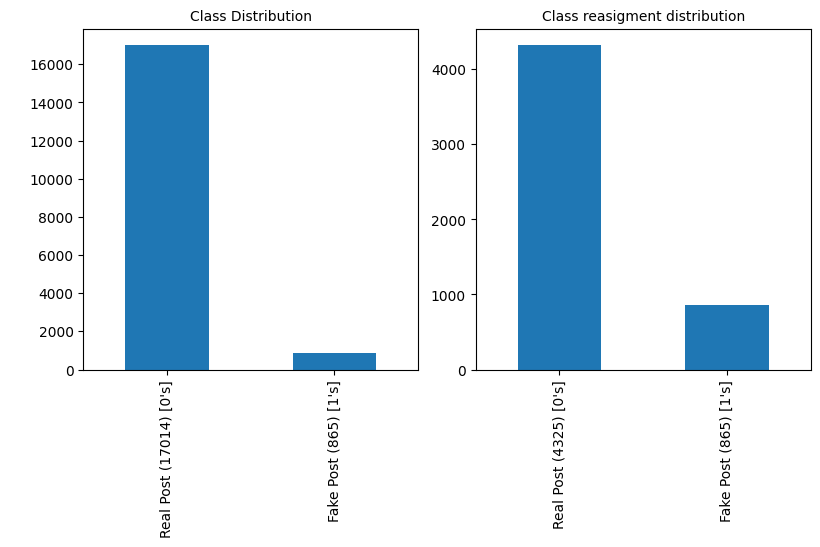

In [11]:
# Plot the original class distribution and the new distribution

fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
plt.tight_layout()
descrip_df["fraudulent"].value_counts().plot.bar (ax = axes[0])
df_underst["fraudulent"].value_counts().plot.bar (ax = axes[1])

axes[0].set_ylabel(' ')
axes[0].set_xticklabels(["Real Post (17014) [0's]", "Fake Post (865) [1's]"])
axes[1].set_ylabel(' ')
axes[1].set_xticklabels(["Real Post (4325) [0's]", "Fake Post (865) [1's]"])

axes[0].set_title('Class Distribution', fontsize=10)
axes[1].set_title('Class reasigment distribution', fontsize=10)

plt.show()

In [0]:
# Assign to target ("fraudulent") and the text ("description")

X = df_underst.iloc[:,1].values
target = df_underst.iloc[:,0].values

In [13]:
# feature extraction using "bag of words" model. Create feature vectors. 
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


count_vectorizer = CountVectorizer( stop_words=stopwords.words('english'))
tfidfconverter = TfidfTransformer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
#  apply the transformations

X_c = count_vectorizer.fit_transform(X)
X_tfidf = tfidfconverter.fit_transform(X_c).toarray()

Dividing data into Training and Test sets

In [0]:
# Break the data in train and test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, target , random_state=580)

**TRAINING THE MODEL**

**Deep Learning Model **

scale the data before any neural net

In [0]:
# Create a StandardScater model and fit it to the training data
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

# Transform the training and testing data using the X_scaler

X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [0]:
# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

In [0]:
# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [0]:
# import dependencies 
import tensorflow as tf
import keras
from keras import layers , models, utils , losses
from keras.layers import Dense, Dropout, Activation
from keras.models import Sequential
# from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop
from keras.callbacks import LearningRateScheduler , History


Adjust the learning rate

In [0]:
epochs=30
learning_rate = 0.05
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [0]:
#  build the architecture of the neural network
input_dim = X_train_scaled.shape[1]

deep_model = Sequential()

deep_model.add(Dense(units=200, kernel_initializer='uniform',activation='relu',input_dim = input_dim))
deep_model.add(Dropout(0.1))
deep_model.add(Dense(units=100, kernel_initializer='uniform',activation='relu'))
deep_model.add(Dense(units=2,kernel_initializer='uniform', activation='softmax'))

In [0]:
# Compile and fit the model
deep_model.compile(optimizer=sgd, 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])

In [52]:
callbacks_list

In [35]:
# train the Model
batch_size=int(input_dim/100)

deep_model_history = deep_model.fit(X_train_scaled, y_train_categorical,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data = (X_test_scaled,y_test_categorical))


Train on 3892 samples, validate on 1298 samples
Epoch 1/30
3892/3892 [==============================] - 2s 535us/step - loss: 0.4841 - accuracy: 0.8273 - val_loss: 0.4164 - val_accuracy: 0.8436
Epoch 2/30
3892/3892 [==============================] - 2s 472us/step - loss: 0.4167 - accuracy: 0.8299 - val_loss: 0.3862 - val_accuracy: 0.8436
Epoch 3/30
3892/3892 [==============================] - 2s 469us/step - loss: 0.3527 - accuracy: 0.8440 - val_loss: 0.3335 - val_accuracy: 0.8706
Epoch 4/30
3892/3892 [==============================] - 2s 464us/step - loss: 0.2497 - accuracy: 0.9018 - val_loss: 0.2966 - val_accuracy: 0.9083
Epoch 5/30
3892/3892 [==============================] - 2s 479us/step - loss: 0.1368 - accuracy: 0.9502 - val_loss: 0.3115 - val_accuracy: 0.9237
Epoch 6/30
3892/3892 [==============================] - 2s 461us/step - loss: 0.0606 - accuracy: 0.9812 - val_loss: 0.2991 - val_accuracy: 0.9199
Epoch 7/30
3892/3892 [==============================] - 2s 471us/step - loss

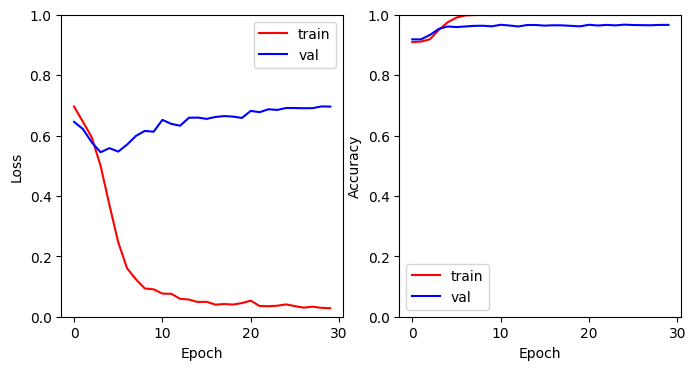

In [37]:
# Plot the loss function
fig, ax = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
ax[0].plot(np.sqrt(deep_model_history.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(deep_model_history.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'Loss', fontsize=10)
ax[0].set_ylim(0, 1)
ax[0].legend()
ax[0].tick_params(labelsize=10)

# Plot the accuracy

ax[1].plot(np.sqrt(deep_model_history.history['accuracy']), 'r', label='train')
ax[1].plot(np.sqrt(deep_model_history.history['val_accuracy']), 'b' ,label='val')
ax[1].set_xlabel(r'Epoch', fontsize=10)
ax[1].set_ylabel(r'Accuracy', fontsize=10)
ax[1].set_ylim(0, 1)
ax[1].legend()
ax[1].tick_params(labelsize=10)

Adjust the the learning rate 

In [0]:
epochs=60
learning_rate = 0.1 # initial learning rate
decay_rate = 0.1
momentum = 0.8
# define the optimizer function
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [0]:
#  build the architecture of the neural network
input_dim = X_train_scaled.shape[1]
batch_size= 200

# build the model
ex_deep_model = Sequential()

ex_deep_model.add(Dense(units=200, kernel_initializer='uniform',activation='relu',input_dim = input_dim))
ex_deep_model.add(Dropout(0.1))
ex_deep_model.add(Dense(units=100, kernel_initializer='uniform',activation='relu'))
ex_deep_model.add(Dense(units=2,kernel_initializer='uniform', activation='softmax'))


In [0]:
# Compile and fit the model
ex_deep_model.compile(optimizer=sgd, 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])

In [0]:
# define the learning rate change 
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate

# learning schedule callback
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [loss_history, lr_rate]    

In [64]:
# train the Model , here use the LearningRatescheduler


ex_deep_model_hystory = ex_deep_model.fit(X_train_scaled, y_train_categorical,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    callbacks=callbacks_list,
                                    verbose=1,
                                    validation_data = (X_test_scaled,y_test_categorical))


Train on 3892 samples, validate on 1298 samples
Epoch 1/60
3892/3892 [==============================] - 4s 915us/step - loss: 0.5240 - accuracy: 0.7980 - val_loss: 0.3902 - val_accuracy: 0.8436
Epoch 2/60
3892/3892 [==============================] - 2s 516us/step - loss: 0.3586 - accuracy: 0.8299 - val_loss: 0.3428 - val_accuracy: 0.8436
Epoch 3/60
3892/3892 [==============================] - 2s 505us/step - loss: 0.2906 - accuracy: 0.8299 - val_loss: 0.3188 - val_accuracy: 0.8436
Epoch 4/60
3892/3892 [==============================] - 2s 512us/step - loss: 0.2453 - accuracy: 0.8299 - val_loss: 0.3047 - val_accuracy: 0.8436
Epoch 5/60
3892/3892 [==============================] - 2s 508us/step - loss: 0.2140 - accuracy: 0.8366 - val_loss: 0.2955 - val_accuracy: 0.8659
Epoch 6/60
3892/3892 [==============================] - 2s 506us/step - loss: 0.1805 - accuracy: 0.8972 - val_loss: 0.2831 - val_accuracy: 0.9099
Epoch 7/60
3892/3892 [==============================] - 2s 511us/step - loss

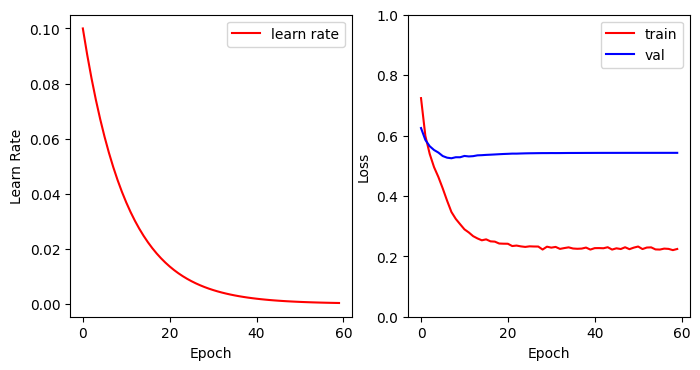

In [65]:
# Plot the loss function
fig, ax = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
ax[0].plot(ex_deep_model_hystory.history['lr'], 'r', label='learn rate')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'Learn Rate', fontsize=10)
# ax[0].set_ylim(0, 1)
ax[0].legend()
ax[0].tick_params(labelsize=10)

# Plot the accuracy

ax[1].plot(np.sqrt(ex_deep_model_hystory.history['loss']), 'r', label='train')
ax[1].plot(np.sqrt(ex_deep_model_hystory.history['val_loss']), 'b' ,label='val')
ax[1].set_xlabel(r'Epoch', fontsize=10)
ax[1].set_ylabel(r'Loss', fontsize=10)
ax[1].set_ylim(0, 1)
ax[1].legend()
ax[1].tick_params(labelsize=10)

Deciding on the batch size and number of epochs

In [0]:
#  build the architecture of the neural network
input_dim = X_train_scaled.shape[1]

# build the model
model = Sequential()

model.add(Dense(units=200, kernel_initializer='uniform',activation='relu',input_dim = input_dim))
model.add(Dropout(0.1))
model.add(Dense(units=100, kernel_initializer='uniform',activation='relu'))
model.add(Dense(units=2,kernel_initializer='uniform', activation='softmax'))

# defining the parameters for RMSprop (keras defaults here)
rms= keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [0]:
# Compile and fit the model

model.compile(optimizer=rms, 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])

In [68]:
# train the Model
batch_size=input_dim
epochs = 30

model_history = model.fit(X_train_scaled, y_train_categorical,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data = (X_test_scaled,y_test_categorical))



Train on 3892 samples, validate on 1298 samples
Epoch 1/30
3892/3892 [==============================] - 2s 546us/step - loss: 0.6592 - accuracy: 0.6249 - val_loss: 0.3662 - val_accuracy: 0.8436
Epoch 2/30
3892/3892 [==============================] - 2s 424us/step - loss: 0.3317 - accuracy: 0.8299 - val_loss: 0.3033 - val_accuracy: 0.9060
Epoch 3/30
3892/3892 [==============================] - 1s 383us/step - loss: 0.2118 - accuracy: 0.9432 - val_loss: 0.2497 - val_accuracy: 0.9137
Epoch 4/30
3892/3892 [==============================] - 2s 388us/step - loss: 0.1385 - accuracy: 0.9586 - val_loss: 0.2234 - val_accuracy: 0.9291
Epoch 5/30
3892/3892 [==============================] - 1s 381us/step - loss: 0.0980 - accuracy: 0.9872 - val_loss: 0.2048 - val_accuracy: 0.9376
Epoch 6/30
3892/3892 [==============================] - 1s 383us/step - loss: 0.0688 - accuracy: 0.9959 - val_loss: 0.1914 - val_accuracy: 0.9391
Epoch 7/30
3892/3892 [==============================] - 1s 381us/step - loss

Test loss: 0.18960290002666746
Test accuracy: 0.9360554814338684


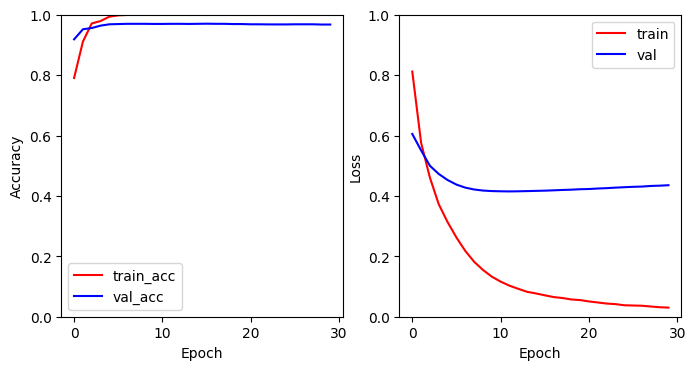

In [69]:
score = model.evaluate(X_test_scaled,y_test_categorical, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

fig, ax = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
ax[0].plot(np.sqrt(model_history.history['accuracy']), 'r', label='train_acc')
ax[0].plot(np.sqrt(model_history.history['val_accuracy']), 'b' ,label='val_acc')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'Accuracy', fontsize=10)
ax[0].legend()
ax[0].set_ylim(0, 1)
ax[0].tick_params(labelsize=10)


ax[1].plot(np.sqrt(model_history.history['loss']), 'r', label='train')
ax[1].plot(np.sqrt(model_history.history['val_loss']), 'b' ,label='val')
ax[1].set_xlabel(r'Epoch', fontsize=10)
ax[1].set_ylabel(r'Loss', fontsize=10)
ax[1].set_ylim(0, 1)
ax[1].legend()
ax[1].tick_params(labelsize=10)


In [0]:
# Evaluate the model using the testing data
model_loss, model_accuracy = deep_model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)

In [0]:
predictions = deep_model.predict(X_test_scaled)
predictions = np.around(predictions , decimals = 0)

In [72]:
# Calculate classification report

print(classification_report(y_test_categorical, predictions,
                            target_names= ["real", "fake"]))

              precision    recall  f1-score   support

        real       0.94      0.98      0.96      1095
        fake       0.88      0.67      0.76       203

   micro avg       0.93      0.93      0.93      1298
   macro avg       0.91      0.82      0.86      1298
weighted avg       0.93      0.93      0.93      1298
 samples avg       0.93      0.93      0.93      1298



Save the model

In [0]:
# save the model
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Save to the model to the local drive
from tensorflow.keras.models import load_model

filenamel = '/content/drive/My Drive/DeepLearningOptimized.h5'
deep_model.save(filenamel)

In [0]:
# Load the model
loaded_deep_model= load_model(filenamel)

model_loss, model_accuracy = loaded_deep_model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)

41/41 - 0s - loss: 0.3375 - accuracy: 0.9176
